# Introduction

*Disclaimer: Although I am an engineer in the self-driving space, this work was done between jobs. I do not claim that any company I have worked for uses the techniques described in this post, and everything described within is public knowledge. I have done my best to avoid technical errors, but please reach out if you spot any mistakes!*


I wrote this notebook to help me understand the path segment generation described in McNaughton 2011 [1] (though it was originally described in [2]). This paper presents a real-time motion planner with several ideas that have been influential in the self-driving space. A key part of the described approach is to be able to generate smooth segments between points in a "state lattice". These segments can later be connected to each other to form a full path for the vehicle to follow. 

<div>
<img src="https://raw.githubusercontent.com/markmliu/path_opt/main/path_generation.png"/ width=500>
</div>
<center><i>Generating smooth paths from initial pose to different future poses</i></center>


In this notebook, we follow the paper and parameterize these  as "cubic polynomial spirals" and use optimization to find the correct parameters of the spiral. You may enjoy reading this if you are interested in planning for autonomous vehicles but find reading the relevant papers too technical - I try to go through this approach without requiring much more background than vector calculus.  I'll switch between plain english, code, and excerpts from the paper to facilitate ease of understanding. Most of the diagrams/equations are from the paper itself. On the coding side, I used `sympy` to do symbolic math and numpy for numerical math. This was my first time using `sympy`, so apologies for the clumsy code.




# Definitions

I will give some "working" definitions for concepts that are necessary for the rest of the post (more rigorous definitions can be found in the paper).

### Pose
We can think of a "pose" as an augmented position of our vehicle. We say augmented because we may also care about other information, such as our heading ($\theta$), the direction of travel and curvature ($\kappa$), the derivative of heading. For our purposes, a pose is represented as the tuple ($x,y, \theta, \kappa$)


### Travel
Travel ($s$) with respect to two points on a curve refers to distance you would travel to get between them going along the curve (as opposed to the euclidian distance between them). 


### Cubic polynomial spiral
A cubic spiral is a curve whose curvature ($\kappa$) is a cubic polynomial function of travel ($s$). If this definition isn't intuitively clear to you, it may help to imagine plotting the curve by taking very small steps along the current heading, recalculating the curvature at the new travel, updating the heading and repeating (in fact, we will do this later in the post to visualize the spirals we are generating). Here's the formal definition:

$ \kappa(s) = \kappa_{0} + \kappa_1 s + \kappa_2 s^2 + \kappa_3 s^3$

A couple of important notes here:
1. There are actually five parameters for the cubic spiral - each $\kappa_i$ as well as an implicit $s_G$ which represents the "final" travel where the curve ends. If we didn't have an $s_G$ the curve would never end and we could not connect it to an endpoint. 

2. There is exactly one cubic polynomial spiral which will connect any two poses as defined here. This is important because we know that once we find *a* solution, we have found *the* solution.



Let's hop into code for a bit - I'm going to encode the cubic spiral definition above by definining curvature in terms of the $\kappa_{0..3}$ (that we'll rename to $a,b,c,d$) and $s$.

In [7]:
from sympy import *
import numpy

# a,b,c,d are the coefficients of the cubic polynomial, s is the variable that represents travel along the spiral.
a,b,c,d, s = symbols("a b c d s")
kappa = a + b*s + c*s**2 + d*s**3


# Reparameterization for numerical stability

Now, at a high level we are going to use numerical optimization to solve for $a,b,c,d$. But the paper notes that when using optimization, you really want to have the variables you're solving for be close in order of magnitude (otherwise, your optimization can fail due to numerical instability). As written, there's no reason that $a,b,c,d$ would be similar orders of magnitude. For example, $a$ could be 0.01 while $b$ could be 1000. So instead of trying to solve directly for them, we use a neat trick - we reparameterize the problem. We introduce four new variables $p_0,..,p_3$ and set them equal to the curvature at $s=0, 1/3* s_G, 2/3*s_G, s_G$ (four evenly spaced points between the starting and final travel, inclusive).

Because the curvature is bounded by the steering limits of the vehicle, this should, in practice, keep our $p0,..,p3$ relatively close together. Once we've solved for $p0,..,p3$, we can substitute back and find the values for $a,b,c,d$, according to the paper:

<div>
<img src="https://raw.githubusercontent.com/markmliu/path_opt/main/reparam_1.png" width=500>
<img src="https://raw.githubusercontent.com/markmliu/path_opt/main/reparam_2.png" width=500>
</div>

But we don't have to take their word for it! Let's check the math using `sympy` below.

In [8]:
p0, p1, p2, p3, sG = symbols("p0 p1 p2 p3 sG")

# Sympy "solve" assumes the expressions passed in are equal to 0, so for example eq1 means
# kappa(0) = p0 and eq1 means kappa(s_G/3) = p1
eq1 = kappa.subs(s,0) - p0
eq2 = kappa.subs(s, sG/3) - p1
eq3 = kappa.subs(s, 2*sG/3) - p2
eq4 = kappa.subs(s, sG) - p3
sol = solve([eq1, eq2, eq3, eq4], {a, b, c, d})

In [9]:
sol # these should match up with the formulas derived in the paper (3.26-3.29)

{a: p0,
 b: (-11*p0 + 18*p1 - 9*p2 + 2*p3)/(2*sG),
 c: (18*p0 - 45*p1 + 36*p2 - 9*p3)/(2*sG**2),
 d: (-9*p0 + 27*p1 - 27*p2 + 9*p3)/(2*sG**3)}

So we can confirm the expressions given in the paper, and this gives us a way to convert solutions for $p_0,..,p_3$ back into solutions for $a,b,c,d$.

In [10]:
a = sol[a]
b = sol[b]
c = sol[c]
d = sol[d]


# Shooting method for optimization

Okay, so let's remember our goal: Given an end pose, we need to find the parameters $p_0,.,p3$ which will connect our cubic spline to it. As we mentioned before, the paper uses the "shooting method" to find the right parameters. So what's that?

At a high level, the shooting method works by:

1. Using your best guess parameters, "shoot" and see where your trajectory lands.
2. Compare your landing point with where you intended to be.
3. Update your guessed parameters to reduce the landing error (will elaborate more on this later)
4. Return to step 1 until "convergence"

In order to do this, we need to be able to do two things:

**1. Determine where a trajectory will land, given the parameters (for step 1 above)**

**2. Relate the error in final pose to the error in chosen parameters (for step 3 above)**

Let's focus on the first one.

# Computing the end configuration from given parameters

Now let's look at how we can use the $p_i$ parameters to compute the configuration (and not just the curvature) at any travel (including the final travel, $s_G$. The paper notes that we can assume our starting point is at $[0,0,0, \kappa_I]$, and provides some equations that give us the different components of our pose (as a function of our parameters and $s$):

<div>
<img src="https://raw.githubusercontent.com/markmliu/path_opt/main/pose_as_fn_of_s.png" width=500>
</div>

That's a lot of symbols - let's start with the easy ones. The equation for curvature $\kappa(s)$ is exactly the same as the definiton of the cubic spiral, and the heading $\theta(s)$ can be computed as the integral (using simple polynomial integral terms). Let's save these in `sympy` now as well.


In [11]:
# if a,b,c,d are known, easy to compute theta(s) or kappa(s)
theta = a*s + b*s**2/2 + c*s**3/3 + d*s**4/4
kappa = a + b*s + c*s**2 + d*s**3

We'll note that $\theta$ is a function of $a,b,c,d$, which can themselves be thought of in terms of $p0,..,p1$ (recall our earlier reparameterization)

In [12]:

theta

p0*s + s**4*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/(8*sG**3) + s**3*(18*p0 - 45*p1 + 36*p2 - 9*p3)/(6*sG**2) + s**2*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/(4*sG)

We can also note that with `sympy`, we can easily take the analytical derivative of $\theta$ with respect to any of the different params (i.e $s_G$ or $p_1$) - this will be useful later


In [13]:
diff(theta, sG)

-3*s**4*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/(8*sG**4) - s**3*(18*p0 - 45*p1 + 36*p2 - 9*p3)/(3*sG**3) - s**2*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/(4*sG**2)

Now what about $x(s)$ and $y(s)$? While $\kappa(s)$ and $\theta(s)$ were relatively straightforward polynominals, $x$ and $y$ contain definite integrals in them. Can we use `sympy` to analytically compute these integrals as well?

In [8]:
# Try it for yourself if you want!
# x = integrate(cos(theta),(s,0,s)) will crash sympy...

Unfortunately, trying to compute the integral as written will actually cause `sympy` to crash. There is a good reason for this - the paper notes that these integrals are special case of the generalized Fresnel integrals and have no closed form solution. Instead, they note that these integrals can be approximated with the "composite Simpson's rule".

<div>
<img src="https://raw.githubusercontent.com/markmliu/path_opt/main/composite_simpson.png" width=500>
</div>

Let's encode this composite simpson's rule in python, so we can call it instead of taking an integral for $x,y$.

In [14]:

# returns the symbolic derivative of the composite simpson intergral of f (from 0 to sG)
# n is the number of parts to break it into, must be even.
def composite_simpson(f, sG, n=8):
    """returns the symbolic derivative of the composite simpson intergral of f (from 0 to sG).
       
       n is the number of parts to break it into, must be even."""
    h = (sG)/n
    
    exp = f.subs(s,0)
    for j in range(1, int(n/2)):
        exp += 2 * f.subs(s,2*j*sG/n)
        
    for j in range(1, int(n/2)+1):
        exp += 4 * (f.subs(s,(2*j-1)*sG/n))
    
    exp += f.subs(s,sG)
        
    exp *= (h/3.0)    
    return exp

Okay, now we can write down $x_{s_G}$ and $y_{s_G}$ in the form specified in (3.42) using composite simpson method instead, which can actually be computed.

In [15]:

x_sG = composite_simpson(cos(theta), sG)
y_sG = composite_simpson(sin(theta), sG)

In [11]:
x_sG

0.0416666666666667*sG*(4*cos(p0*sG/8 + sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/256 + sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/32768 + sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/3072) + 2*cos(p0*sG/4 + sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/64 + sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/2048 + sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/384) + 4*cos(3*p0*sG/8 + 9*sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/256 + 81*sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/32768 + 9*sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/1024) + 2*cos(p0*sG/2 + sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/16 + sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/128 + sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/48) + 4*cos(5*p0*sG/8 + 25*sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/256 + 625*sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/32768 + 125*sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/3072) + 2*cos(3*p0*sG/4 + 9*sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/64 + 81*sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/2048 + 9*sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/128) + 4*cos(7*p0*sG/8 + 49*sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/256 + 2401*sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/32768 + 343*sG*(1

Remember, composite simpson's works by replacing the integral with a sum over $n$ components, so this looks about right.

Now if we've done everything correctly, we should be able to visualize our trajectory ending point (and any arbitrary point along our trajectory!) given a set of parameters. 

Let's double-check our math/code by visually plotting a trajectory for some set of parameters.
I'll choose some parameters which:
 - should be 20 meters long
 - starts with 0 curvature and linearly increases to 0.3 by $s_G$.
 
Below is some code for plotting the trajectory. I'm just doing a few simple things:
 - Using `sympy`'s "eval" function which plugs in concrete values for different parameters
 - Using `matplotlib` to plot the evaluation for 100 values of $s$ between 0 and $s_G$.
 - I plot three things: The curve itself, the heading as a function of travel and the curvature as a function of travel.
 
These should serve as a decent sanity check for us.

In [21]:
# lets say we have some initial guess
p0_g = 0
p1_g = 0.1
p2_g = 0.2
p3_g = 0.3
sG_g = 20

p_g = (p0_g, p1_g, p2_g, p3_g, sG_g)

def eval_guess(p_g, s_eval=None):
    p0_g = p_g[0]
    p1_g = p_g[1]
    p2_g = p_g[2]
    p3_g = p_g[3]
    sG_g = p_g[4]
    if s_eval == None:
        s_eval = sG_g
    # note that i set s and sG to s_eval for x,y but sG to sG_g for theta.
    # this is not technically correct - this is because i use sG as the argument in composite simpson when it should 
    # really be s_eval. has to do with the way I'm re-using variable names in sympy
    # and i don't understand the correct way to do it.
    x_sG_g = x_sG.subs([(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (sG, s_eval)])
    y_sG_g = y_sG.subs([(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (sG, s_eval)])
    theta_sG_g = theta.subs([(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (s, s_eval), (sG, sG_g)])
    ka_g = kappa.subs([(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (s, s_eval), (sG, sG_g)])
    return x_sG_g, y_sG_g, theta_sG_g, ka_g

<class 'float'>


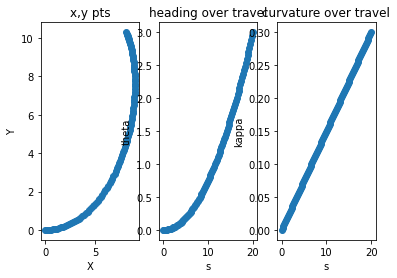

In [22]:
# code to plot the trajectory for a set of parameters
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot(p_g, iteration=None, q_goal=None):
    xs = []
    ys = []
    ths = []
    kas = []
    sG_g = float(p_g[4])
    print(type(sG_g))
    ss = np.linspace(0, sG_g, 100)
    for s in ss:
        x,y,th,ka = eval_guess(p_g, s)
        xs.append(x)
        ys.append(y)
        ths.append(th)
        kas.append(ka)
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    iteration_str = "iteration: " + str(iteration) if iteration else ""
    fig.suptitle(iteration_str)

    ax1.set_title('x,y pts')
    ax1.plot(xs,ys, 'o')
    ax1.set(xlabel='X', ylabel='Y')
    if q_goal:
        ax1.plot(q_goal[0],q_goal[1],'r+') # plot goal x,y
    
    ax2.set_title('heading over travel')
    ax2.plot(ss, ths, 'o')
    ax2.set(xlabel='s', ylabel='theta')
    if q_goal:
        ax2.axhline(q_goal[2],color='r')

    ax3.set_title('curvature over travel')
    ax3.plot(ss, kas, 'o')
    ax3.set(xlabel='s', ylabel='kappa')
    if q_goal:
        ax3.axhline(q_goal[3], color='r')
    
    plt.show()

plot(p_g)

This looks about right - the curvature is continuous, matches the specified values at different travels and the x,y, heading look continuous. Yay!

Next let's look at how we "correct" the initial parameters to get closer to our target pose.

# Relating our output error to parameter error

So let's say we've started with some initial guess for the parameters, and they give us a trajectory that lands not quite on our target pose. Next, we need to relate the error in our output to an error to our input. It's time to introduce the Jacobian.

## Jacobian
We can think of the Jacobian as the vector calculus analogue to the derivative. A derivative tells us how to relate a change in the output of a function to the change in input. For a vector function, the inputs and outputs can both be vectors. So the Jacobian of a function is simply the matrix that specifies how the $i$th output varies with respect to the $j$th input. In our case, we want to know how the different components of the end pose ($x,y,\theta,\kappa$) are affected by the different input parameters ($p_0,..,p3, s_G$). 



<div>
<img src="https://raw.githubusercontent.com/markmliu/path_opt/main/jacobian.png" width=500>
</div>

So why do we have a 3x3 matrix if there are 5 inputs and 4 outputs? $p_0$ and $p_3$ can be skipped as inputs, since they are fixed for a given end pose (recall that $p_0$ is equal to initial curvature and $p_3$ is equal to final curvature). $\kappa$ can also be omitted as an output, since the final curvature is specified by the end pose. This leaves 3 unfixed input parameters ($p_1, p_2, s_G$) and 3 unfixed output parameters ($x,y,\theta$). Let's encode the Jacobian into `sympy` as well.

In [23]:
def Jacobian(p_g):
    p0_g = p_g[0]
    p1_g = p_g[1]
    p2_g = p_g[2]
    p3_g = p_g[3]
    sG_g = p_g[4]
    
    substitutions = [(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (sG, sG_g), (s, sG_g)]
    
    J11 = diff(x_sG, p1).subs(substitutions)
    J12 = diff(x_sG, p2).subs(substitutions)
    J13 = diff(x_sG, sG).subs(substitutions)
    J21 = diff(y_sG, p1).subs(substitutions)
    J22 = diff(y_sG, p2).subs(substitutions)
    J23 = diff(y_sG, sG).subs(substitutions)
    J31 = diff(theta, p1).subs(substitutions)
    J32 = diff(theta, p2).subs(substitutions)
    J33 = diff(theta, sG).subs(substitutions)
    J = Matrix([[J11,J12,J13], [J21,J22, J33], [J31,J32,J33]])
    
    return J

Here's where we really got to take advantage of sympy - rather than having to numerically calculate the Jacobian anywhere we were able to take all of our derivatives symbolically, which is both faster and more accurate. Being able to do this is also incredibly useful for a real-time planner (though you most likely wouldn't be using python for that)

In [24]:
J = Jacobian(p_g)

In [25]:
shape(J)

(3, 3)

# Putting it all together

Okay, so we've got the two pieces we were looking for: 

**1. Determine where a trajectory will land, given the parameters (for step 1 above)**

**2. Relate the error in final pose to the error in chosen parameters (for step 3 above)**

We said that once we had these, we could use the shooting method to calculate the correct paramters. The shooting method says to update the parameters systematically until we land on the goal, but does not specify how to update them. This paper uses Newton's method to update the parameter guess. 

## Newton's method 

Newton's method iteratively find the roots (zeros) of a function using just its derivative (or Jacobian, in our case). For us, we can use it to find the root of $f=q_g - q_p$ (the difference between the goal pose and the pose from our parameters). Finding the root of that function will get the error to zero, giving us the correct parameters. So how does it work? The Wikipedia article has a great visual explanation.
<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e0/NewtonIteration_Ani.gif" width=500>
</div>

Essentially, Newton's method works by starting with a guess, taking a linear approximation to the function at that guess and extrapolating to find the "zero" of that approximation. This becomes our next guess, and we repeat. Under certain conditions, this is guaranteed to converge to a true zero of the function. The paper describes this formally below:

<div>
<img src="https://raw.githubusercontent.com/markmliu/path_opt/main/newtons_method.png" width=200>
</div>

Okay, let's put it all into code! I'll set up a problem with an initial and goal pose, and start off with some initial guess for the parameters. I'll use the shooting method with Newton's method to update the parameters - we'll pause and look at some of the intermediate trajectories we generated to see how the updates change our trajectory!

In [26]:
import math
# k_i = 0.2
# k_goal = 1.0

k_i = 0.0 
k_goal = 0.2
x_goal = 10.0
y_goal = 5.0


# initial point is (0,0,0,kappa_i)
q_i = Matrix([0.0, 0.0, 0.0, k_i])
# destination point is (10,20,pi/4,0.2)
q_goal = Matrix([x_goal, y_goal, 0.0, k_goal])


# lets say we have some initial guess (p0 must match initial curvature, p3 must match actual final curvature)
p0_g = k_i
p1_g = 0.0
p2_g = 0.0
p3_g = k_goal
sG_g = 15.0

p_g = Matrix([p0_g, p1_g, p2_g, p3_g, sG_g])

intermediates = []

num_iters = 10
for i in range(0,num_iters+1):

    J = Jacobian(p_g)
    q_sG_g = Matrix(list(eval_guess(p_g)))
    d_q = q_goal - q_sG_g
    d_q.row_del(3) # delete the curvature, since we don't include it in the jacobian
    
    d_p = J.inv() * d_q 

    # add back 0s for p0 and p3 index (0 and 3)
    d_p = d_p.row_insert(0, Matrix([0]))
    d_p = d_p.row_insert(3, Matrix([0]))
    
    p_g += d_p
    if i == 0 or i == 3 or i == 7: # just save some intermediates for plotting
        intermediates.append((p_g, i))

intermediates.append((p_g, num_iters))
print("final ps:", p_g)    
eval_guess(p_g)


final ps: Matrix([[0], [0.179749098336037], [-0.247038077524759], [0.200000000000000], [11.9181828929782]])


(9.99986981345695, 4.98669898930157, -0.00278131292041905, 0.199999999999998)

Okay let's see how we did! Let's first look at iteration 0. I've drawn a red cursor in the leftmost plot to illustrate where our curve should end in $x,y$. Similarly, I've drawn red lines in the next two plots to show where the heading should end by the final travel $s_G$, and same with the curvature.

<class 'float'>


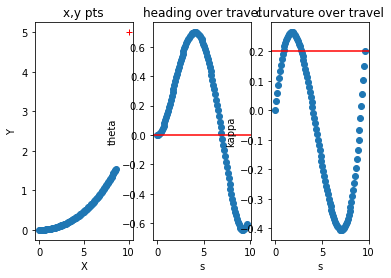

In [28]:
# plot iteration 0
guess, i = intermediates[0]
plot(guess, i, q_goal)

This first attempt at the trajectory is very far off. We can see that the trajectory ends at around (8,2) when the target is around (10,5). Similarly, the heading ends at -0.4 when it should be around 0.0. Note that the final curvature is correct - as we noted earlier this is fixed from the start and will always be correct. Let's look at a later iteration.

<class 'float'>


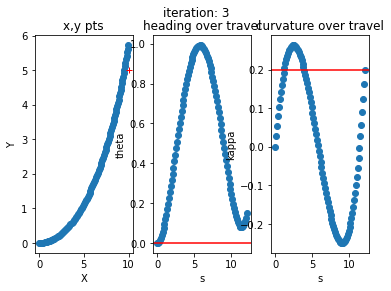

In [29]:
guess, i = intermediates[1]
plot(guess, i, q_goal)

Here, at iteration 3, we're doing better. The trajectory endpoint is around (10,6) and the final heading is closer as well.

<class 'float'>


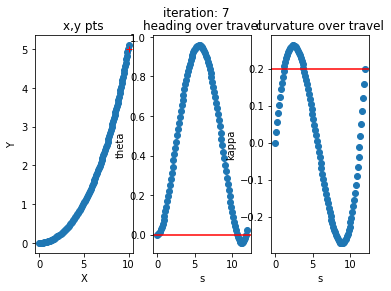

In [30]:
guess, i = intermediates[2]
plot(guess, i, q_goal)

On iteration 7 we've gotten even closer.

<class 'float'>


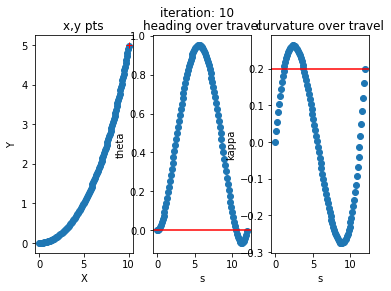

In [31]:
guess, i = intermediates[3]
plot(guess, i, q_goal)

And on iteration 10 it looks dead-on. Note that I didn't really implement the convergence criteria, but you could implement it pretty easily by comparing the norm of the error with some threshold.

So we've found a guess that lands us at the correct end pose! Last step is to transform this guess back into the $a,b,c,d$ parameters we originally wanted to compute.

In [37]:
substitutions = [(p0, guess[0]), (p1, guess[1]), (p2, guess[2]), (p3, guess[3]), (sG, guess[4]), (s, guess[4])]
a_final = a.subs(substitutions)
b_final = b.subs(substitutions)
c_final = d.subs(substitutions)
d_final = d.subs(substitutions)
sG_final = guess[4]
a_final, b_final, c_final, d_final, sG_final

(0,
 0.245793613018951,
 0.00393504919871011,
 0.00393504919871011,
 11.9181828929782)

# Conclusion

We learned about how the McNaughton paper generates smooth paths between arbitrary robot poses. In doing so, we took advantage of both symbolic and numerical math (when appropriate) to get a useful, practical algorithm. One of the things I love about working in robotics is that you have to mix and match techniques from lot of different fields. For a curious mind, this provides endless opportunity to learn. I hope you enjoyed following along! 



# References

[1] https://www.ri.cmu.edu/pub_files/2011/7/mcnaughton-thesis.pdf

[2] https://www.cs.cmu.edu/~alonzo/pubs/papers/ijrr02TrajGen.pdf

[3] https://ocw.snu.ac.kr/sites/default/files/NOTE/Lecture%2011_0.pdf

# Appendix

Did not implement the initial guess algorithm, but its described here.

## Initial guess algorithm

<div>
<img src="https://raw.githubusercontent.com/markmliu/path_opt/main/initial_guess.png" width=500>
</div>